In [1]:
# package to split train and validate set
from sklearn.model_selection import train_test_split

# pytorch package
import torch
from torch import nn,optim
from torch.utils.data import DataLoader,Dataset
import torchvision.models as models
from tqdm import tqdm
from utility.myutility import random_sample, tensor_to_img, save_img
from layers.GraphConvolution import GraphConvolution
from layers.MultiHeadGAT import MultiHeadGAT
from layers.AttentionCrop import AttentionCropLayer

import os
import numpy as np
import pandas as pd
import logging
import datetime

# Setting

In [2]:
batch_size = 256
epochs = 200
patient = 200
learning_rate = 0.001
test_batch = 512
in_channel = 1
chunk_interval = 1
model_name = 'model_saver'
train_save_name = 'TFG-Net_training_stage'
root_path = '/home/ices/work/TI_Estimation/'
train_range = (2010, 2017)
test_range = (2018, 2020)

In [3]:
model_dir = './'+model_name + '/'
# if os.path.exists(model_dir) == False:
#     os.makedirs(model_dir)
# else:
#     os._exit(-1)
# logging.basicConfig(filename=model_dir + 'TFG-Net.log', encoding='utf-8', level=logging.INFO)

In [4]:
data_info = pd.read_csv(root_path + '/data/gridsat.path.ibtr.windspeed.csv')

In [5]:
train_info = data_info[(data_info["YEAR"]>=train_range[0]) & (data_info["YEAR"]<=train_range[1])].copy()

In [6]:
X = train_info["PATH"].to_numpy()
Y = train_info["WIND_SPEED"].to_numpy()
Y = np.expand_dims(Y, axis=1)

In [7]:
min_max_img = np.load(root_path + '/data/gridsat.img.min.max.npy')

In [8]:
min_img = min_max_img[0]
max_img = min_max_img[1]

In [9]:
min_img, max_img

(10.0, 348.30999755859375)

In [10]:
X.shape,Y.shape

((39110,), (39110, 1))

In [11]:
# train_valid_index = sequence_chunks(X)
train_valid_index = [*range(0, len(X))]
len(train_valid_index)

39110

In [12]:
class LiverDataset(Dataset):
    def __init__(self, data, ):
        self.data = data
        
    def __getitem__(self, index):
        img = np.load(X[self.data[index]])
        img_normal = (img - min_img)/(max_img - min_img)
        img_t = img_normal[:,22:-23, 22:-23]
#         img_t = img_normal[:,122:180,122:180]
        return img_t.astype(np.float32), Y[self.data[index]].astype(np.float32)

    def __len__(self):
        return len(self.data)

In [13]:
#split training data and validation data 
train_index, valid_index = train_test_split(train_valid_index,test_size=0.2,shuffle = True)

#check data shape 
print("training index shape:",len(train_index))
print("validation index shape:",len(valid_index))

#form dataset
train_indexset = LiverDataset(train_index)
valid_indexset = LiverDataset(valid_index)

#form dataloader
train_index_loader = DataLoader(dataset=train_indexset,batch_size=batch_size,shuffle=True,)
valid_index_loader = DataLoader(dataset=valid_indexset,batch_size=batch_size,shuffle=True,)

training index shape: 31288
validation index shape: 7822


# Graph

In [14]:
adj = np.load(root_path +'data/adj.npy')

In [15]:
center_wind = np.load(root_path + 'data/center_wind.npy')

In [16]:
adj.shape, center_wind.shape

((15, 15), (15, 1))

# Model

In [17]:
class TFGNet(nn.Module):
    def __init__(self, num_classes, img_scale=448):
        super(TFGNet, self).__init__()
        
        #backbone 1
        self.b1_resnet_cnn = models.resnet18(num_classes=num_classes)
        self.b1_feature_extractor = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
        )
        
        self.b1_resnet_cnn = nn.Sequential(*( list(self.b1_resnet_cnn.children())[4:-2] ))
        self.b1_pooling = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            nn.Flatten()
        )
        
        # FTFE
        self.b2_resnet_cnn = models.resnet18(num_classes=num_classes)
        self.b2_feature_extractor = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
        )
            
        self.b2_resnet_cnn = nn.Sequential(*( list(self.b2_resnet_cnn.children())[4:-2] ))
        self.b2_pooling = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            nn.Flatten()
        )

        self.conbine_fc = nn.Linear(in_features=512+512, out_features=512, bias=True)
        self.fc = nn.Linear(in_features=512+16, out_features=1, bias=True)
        
        self.crop_resize = AttentionCropLayer()
        
        self.apn1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 3),
            nn.Sigmoid(),
        )
        
        # WTRG
        self.gcn1 = GraphConvolution(in_features=1, out_features=8)
        self.gcn2 = GraphConvolution(in_features=8, out_features=16)
        self.gat1 = MultiHeadGAT(in_features=16, out_features=16, num_heads=3)
        
        self.center_wind = torch.tensor(center_wind).cuda()
        self.adj = torch.tensor(adj).cuda()
        
        self.conv = nn.Conv1d(15, 1, kernel_size=3,stride=1,padding=1)

    def forward(self, x):
        batch_size = x.shape[0]
        rescale_tl = torch.tensor([1, 1, 0.5], requires_grad=False).cuda()
        
        # forward @scale-1
        extract_s1 = self.b1_feature_extractor(x)
        feature_s1 = self.b1_resnet_cnn(extract_s1)
        pool_s1 = self.b1_pooling(feature_s1)
        _attention_s1 = self.apn1(pool_s1.view(-1, 512))
        attention_s1 = _attention_s1*rescale_tl
        resized_s1 = self.crop_resize(x, attention_s1 * x.shape[-1])
        
        # forward @scale-2
        extract_s2 = self.b2_feature_extractor(resized_s1)  # torch.Size([1, 320, 7, 7])
        feature_s2 = self.b2_resnet_cnn(extract_s2)
        pool_s2 = self.b2_pooling(feature_s2)
        
        out = torch.cat([pool_s1.view(-1, 512), pool_s2.view(-1, 512)], dim=-1)
        out = self.conbine_fc(out)
        
        # gcn 
        gcn_out = self.gcn1(self.center_wind, self.adj)
        gcn_out = self.gcn2(gcn_out, self.adj)
        gcn_out = self.gat1(gcn_out, self.adj)
        
        gcn_out = torch.unsqueeze(gcn_out,dim=0)
        gcn_out = self.conv(gcn_out)
        gcn_out = torch.squeeze(gcn_out,dim=0)
        gcn_out = gcn_out.repeat(batch_size,1)
        
        out = torch.cat([out, gcn_out], dim=-1)
        
        pred = self.fc(out)
                
        return pred, [feature_s1, feature_s2], [attention_s1, ], [resized_s1, ]

In [18]:
model = TFGNet(num_classes=1)

In [19]:
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
start_epoch = 0
min_val_loss = float('inf')
model = nn.DataParallel(model,device_ids=[0, 1, ])
model.to("cuda")

DataParallel(
  (module): TFGNet(
    (b1_resnet_cnn): Sequential(
      (0): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


# Trainer

In [20]:
# checkpoint = torch.load(model_dir + '/' + 'best_validate_model.pth')
# print(checkpoint.keys())
# min_val_loss = checkpoint['min_val_loss']
# optimizer.load_state_dict(checkpoint['optimizer'])
# model.load_state_dict(checkpoint['model'])
# start_epoch = checkpoint['epoch']
# logging.info('resume training '+model_name)

  0%|          | 0/123 [00:00<?, ?it/s]

epochs [1/200]


  0%|          | 0/123 [00:00<?, ?it/s]

Saving Model in epoch 1
cost:88.000000s total_train_loss: 17.16737885 val_loss: 14.42577737
epochs [2/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 14.77588781 val_loss: 18.02853043
epochs [3/200]


  0%|          | 0/123 [00:00<?, ?it/s]

Saving Model in epoch 3
cost:82.000000s total_train_loss: 14.33358074 val_loss: 12.39210732
epochs [4/200]


  0%|          | 0/123 [00:00<?, ?it/s]

Saving Model in epoch 4
cost:84.000000s total_train_loss: 11.51936378 val_loss: 10.16503648
epochs [5/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 11.82862280 val_loss: 11.03732660
epochs [6/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 10.83372729 val_loss: 10.97438988
epochs [7/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 10.40711073 val_loss: 10.71841944
epochs [8/200]


100%|██████████| 31/31 [00:11<00:00,  2.67it/s]


Saving Model in epoch 8


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 9.83379627 val_loss: 9.89468193
epochs [9/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 9.52052106 val_loss: 10.31377180
epochs [10/200]


100%|██████████| 31/31 [00:11<00:00,  2.74it/s]


Saving Model in epoch 10


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 9.57195158 val_loss: 9.83562697
epochs [11/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 9.14907336 val_loss: 10.48388463
epochs [12/200]


100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


Saving Model in epoch 12


  0%|          | 0/123 [00:00<?, ?it/s]

cost:84.000000s total_train_loss: 9.36146595 val_loss: 8.84229312
epochs [13/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 8.77921952 val_loss: 9.24211502
epochs [14/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 8.72162530 val_loss: 8.92506532
epochs [15/200]


100%|██████████| 31/31 [00:11<00:00,  2.70it/s]


Saving Model in epoch 15


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 8.64291658 val_loss: 8.69271915
epochs [16/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 8.58778876 val_loss: 9.19836823
epochs [17/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 8.57499501 val_loss: 9.18347116
epochs [18/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 8.61307131 val_loss: 8.89190938
epochs [19/200]


100%|██████████| 31/31 [00:11<00:00,  2.64it/s]


Saving Model in epoch 19


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 8.38317497 val_loss: 8.63197722
epochs [20/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 8.22883627 val_loss: 9.41050059
epochs [21/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 8.36841552 val_loss: 8.74099965
epochs [22/200]


100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Saving Model in epoch 22


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 8.24530310 val_loss: 8.51917558
epochs [23/200]


100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


Saving Model in epoch 23


  0%|          | 0/123 [00:00<?, ?it/s]

cost:84.000000s total_train_loss: 8.00277377 val_loss: 8.34863590
epochs [24/200]


100%|██████████| 31/31 [00:11<00:00,  2.70it/s]


Saving Model in epoch 24


  0%|          | 0/123 [00:00<?, ?it/s]

cost:84.000000s total_train_loss: 7.90544823 val_loss: 8.24480758
epochs [25/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 7.90548510 val_loss: 8.47116469
epochs [26/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 7.96637985 val_loss: 8.79169967
epochs [27/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 7.72650283 val_loss: 8.32991205
epochs [28/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 7.72132239 val_loss: 8.62760801
epochs [29/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 7.60007725 val_loss: 8.37644795
epochs [30/200]


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Saving Model in epoch 30


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 7.53091936 val_loss: 7.99115203
epochs [31/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 7.45055397 val_loss: 8.05534009
epochs [32/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 7.35887781 val_loss: 8.47898322
epochs [33/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 7.19199169 val_loss: 7.99384669
epochs [34/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 7.09988896 val_loss: 8.09761566
epochs [35/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 6.99445642 val_loss: 8.24274269
epochs [36/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 6.85190286 val_loss: 8.04469684
epochs [37/200]


100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Saving Model in epoch 37


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 6.73585655 val_loss: 7.88894767
epochs [38/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 6.71349203 val_loss: 8.21824464
epochs [39/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 6.64176188 val_loss: 8.47855237
epochs [40/200]


100%|██████████| 31/31 [00:11<00:00,  2.72it/s]


Saving Model in epoch 40


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 6.55768461 val_loss: 7.79807269
epochs [41/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 6.35543487 val_loss: 7.96654995
epochs [42/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 6.29567556 val_loss: 8.08250883
epochs [43/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 5.98968927 val_loss: 7.95722414
epochs [44/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 6.07466241 val_loss: 7.85558822
epochs [45/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 5.92522510 val_loss: 7.82959969
epochs [46/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 5.81421479 val_loss: 7.87090860
epochs [47/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 5.66771439 val_loss: 7.93309490
epochs [48/200]


100%|██████████| 31/31 [00:11<00:00,  2.73it/s]


Saving Model in epoch 48


  0%|          | 0/123 [00:00<?, ?it/s]

cost:84.000000s total_train_loss: 5.84825039 val_loss: 7.76130498
epochs [49/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 5.49040843 val_loss: 7.79542563
epochs [50/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 5.36701227 val_loss: 8.40084559
epochs [51/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 5.57007266 val_loss: 8.49667971
epochs [52/200]


100%|██████████| 31/31 [00:11<00:00,  2.72it/s]


Saving Model in epoch 52


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 5.23700085 val_loss: 7.71950194
epochs [53/200]


100%|██████████| 31/31 [00:11<00:00,  2.65it/s]


Saving Model in epoch 53


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 5.04654518 val_loss: 7.71771305
epochs [54/200]


100%|██████████| 31/31 [00:11<00:00,  2.71it/s]


Saving Model in epoch 54


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 5.02511548 val_loss: 7.63794997
epochs [55/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 4.88425720 val_loss: 7.78574690
epochs [56/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 4.79136324 val_loss: 7.83454389
epochs [57/200]


100%|██████████| 31/31 [00:11<00:00,  2.70it/s]


Saving Model in epoch 57


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 4.71735916 val_loss: 7.49826281
epochs [58/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 4.54146870 val_loss: 7.73750353
epochs [59/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 4.82628177 val_loss: 7.58192215
epochs [60/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 4.58396491 val_loss: 7.61317613
epochs [61/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 4.63555838 val_loss: 8.03594248
epochs [62/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 4.44293696 val_loss: 7.57516492
epochs [63/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 4.30128234 val_loss: 7.86826161
epochs [64/200]


100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


Saving Model in epoch 64


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 4.37941427 val_loss: 7.37735928
epochs [65/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 4.05755673 val_loss: 7.60262076
epochs [66/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 4.05989269 val_loss: 7.71652182
epochs [67/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 4.08258036 val_loss: 7.49548764
epochs [68/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.86576045 val_loss: 7.86806099
epochs [69/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 4.03476500 val_loss: 7.55926440
epochs [70/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.92428248 val_loss: 7.49559578
epochs [71/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.93230059 val_loss: 7.43745828
epochs [72/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.77088031 val_loss: 7.50305631
epochs [73/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.65721856 val_loss: 7.74699279
epochs [74/200]


100%|██████████| 31/31 [00:11<00:00,  2.76it/s]


Saving Model in epoch 74


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 3.44223802 val_loss: 7.33735643
epochs [75/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.46908072 val_loss: 7.37780031
epochs [76/200]


100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


Saving Model in epoch 76


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 3.32306736 val_loss: 7.33646994
epochs [77/200]


100%|██████████| 31/31 [00:11<00:00,  2.72it/s]


Saving Model in epoch 77


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 3.27699669 val_loss: 7.26948227
epochs [78/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.23650285 val_loss: 8.34706011
epochs [79/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.64239623 val_loss: 7.40529067
epochs [80/200]


100%|██████████| 31/31 [00:11<00:00,  2.68it/s]


Saving Model in epoch 80


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 3.15766061 val_loss: 7.18980826
epochs [81/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.06362091 val_loss: 7.28408401
epochs [82/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.11966301 val_loss: 7.30187559
epochs [83/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.06858512 val_loss: 7.35968450
epochs [84/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.10290716 val_loss: 7.60612428
epochs [85/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.19591950 val_loss: 7.23908307
epochs [86/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.85015758 val_loss: 7.27800442
epochs [87/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 2.98229205 val_loss: 7.62096980
epochs [88/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.88162338 val_loss: 7.28295712
epochs [89/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.99374673 val_loss: 7.23710272
epochs [90/200]


100%|██████████| 31/31 [00:11<00:00,  2.71it/s]


Saving Model in epoch 90


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 2.76539453 val_loss: 7.08668110
epochs [91/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 2.77883718 val_loss: 7.12611603
epochs [92/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.76950161 val_loss: 8.02908525
epochs [93/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.01469623 val_loss: 7.26552316
epochs [94/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.96088247 val_loss: 7.22907700
epochs [95/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.78733867 val_loss: 7.19874037
epochs [96/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.79852724 val_loss: 7.24533835
epochs [97/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.78915897 val_loss: 7.19976739
epochs [98/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 2.68109544 val_loss: 7.22532832
epochs [99/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 2.59389349 val_loss: 7.14388058
epochs [100/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.70099236 val_loss: 7.23339047
epochs [101/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 2.69594718 val_loss: 7.14827098
epochs [102/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 2.52758548 val_loss: 7.15362110
epochs [103/200]


100%|██████████| 31/31 [00:11<00:00,  2.66it/s]


Saving Model in epoch 103


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 2.50323787 val_loss: 7.06651166
epochs [104/200]


100%|██████████| 31/31 [00:11<00:00,  2.68it/s]


Saving Model in epoch 104


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 2.71654475 val_loss: 7.05685865
epochs [105/200]


100%|██████████| 31/31 [00:11<00:00,  2.67it/s]


Saving Model in epoch 105


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 2.57953310 val_loss: 7.05608865
epochs [106/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 3.03111110 val_loss: 7.35654932
epochs [107/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.16545017 val_loss: 7.42070999
epochs [108/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 3.02575011 val_loss: 7.20677004
epochs [109/200]


100%|██████████| 31/31 [00:11<00:00,  2.79it/s]


Saving Model in epoch 109


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 2.98614744 val_loss: 6.99811331
epochs [110/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.96500527 val_loss: 7.13865040
epochs [111/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.85154265 val_loss: 7.16881611
epochs [112/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.72247722 val_loss: 7.10253300
epochs [113/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.74100995 val_loss: 7.23521828
epochs [114/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.59157750 val_loss: 7.02839319
epochs [115/200]


100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


Saving Model in epoch 115


  0%|          | 0/123 [00:00<?, ?it/s]

cost:84.000000s total_train_loss: 2.51458359 val_loss: 6.95566208
epochs [116/200]


100%|██████████| 31/31 [00:11<00:00,  2.68it/s]


Saving Model in epoch 116


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 2.59746503 val_loss: 6.94808683
epochs [117/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.60333318 val_loss: 7.01506413
epochs [118/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.63157476 val_loss: 6.97812806
epochs [119/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 2.47267512 val_loss: 6.96518584
epochs [120/200]


100%|██████████| 31/31 [00:11<00:00,  2.68it/s]


Saving Model in epoch 120


  0%|          | 0/123 [00:00<?, ?it/s]

cost:84.000000s total_train_loss: 2.51050150 val_loss: 6.90215358
epochs [121/200]


100%|██████████| 31/31 [00:11<00:00,  2.77it/s]


Saving Model in epoch 121


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 2.43108807 val_loss: 6.85136970
epochs [122/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 2.32923790 val_loss: 6.94030822
epochs [123/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.37417413 val_loss: 6.99365222
epochs [124/200]


100%|██████████| 31/31 [00:11<00:00,  2.62it/s]


Saving Model in epoch 124


  0%|          | 0/123 [00:00<?, ?it/s]

cost:84.000000s total_train_loss: 2.41387727 val_loss: 6.79713511
epochs [125/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 2.31207478 val_loss: 7.01669242
epochs [126/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.31399800 val_loss: 6.89625180
epochs [127/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 2.23639223 val_loss: 6.91724523
epochs [128/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.25928977 val_loss: 6.83223421
epochs [129/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.16474544 val_loss: 6.90671449
epochs [130/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.21009985 val_loss: 6.89575154
epochs [131/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 2.26810098 val_loss: 6.90601547
epochs [132/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.43540562 val_loss: 7.15367522
epochs [133/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.27054100 val_loss: 6.81554191
epochs [134/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.22573961 val_loss: 6.87143687
epochs [135/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.17441858 val_loss: 6.93750963
epochs [136/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.19775570 val_loss: 6.97264424
epochs [137/200]


100%|██████████| 31/31 [00:11<00:00,  2.67it/s]


Saving Model in epoch 137


  0%|          | 0/123 [00:00<?, ?it/s]

cost:84.000000s total_train_loss: 2.19872189 val_loss: 6.73425771
epochs [138/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 2.18548445 val_loss: 6.77121261
epochs [139/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.19110802 val_loss: 6.79852856
epochs [140/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.23490067 val_loss: 6.77656955
epochs [141/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.11682612 val_loss: 6.85884630
epochs [142/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.25512518 val_loss: 6.90640282
epochs [143/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.25027440 val_loss: 6.99185682
epochs [144/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 2.10082028 val_loss: 6.75685929
epochs [145/200]


100%|██████████| 31/31 [00:11<00:00,  2.71it/s]


Saving Model in epoch 145


  0%|          | 0/123 [00:00<?, ?it/s]

cost:84.000000s total_train_loss: 1.97225128 val_loss: 6.71897956
epochs [146/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.90810739 val_loss: 7.42728724
epochs [147/200]


100%|██████████| 31/31 [00:11<00:00,  2.69it/s]


Saving Model in epoch 147


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 2.06574093 val_loss: 6.71873365
epochs [148/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.91303192 val_loss: 6.75889775
epochs [149/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.99661835 val_loss: 6.76745327
epochs [150/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.93866866 val_loss: 6.73800239
epochs [151/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.88807912 val_loss: 6.72144439
epochs [152/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.88828960 val_loss: 6.76775643
epochs [153/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.81562100 val_loss: 6.72422286
epochs [154/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.91114065 val_loss: 6.73781518
epochs [155/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.83086277 val_loss: 6.76440956
epochs [156/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.92548957 val_loss: 6.77818351
epochs [157/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.88807117 val_loss: 6.72507038
epochs [158/200]


100%|██████████| 31/31 [00:11<00:00,  2.74it/s]


Saving Model in epoch 158


  0%|          | 0/123 [00:00<?, ?it/s]

cost:84.000000s total_train_loss: 1.99277162 val_loss: 6.66188422
epochs [159/200]


100%|██████████| 31/31 [00:11<00:00,  2.72it/s]


Saving Model in epoch 159


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 1.82059823 val_loss: 6.63572788
epochs [160/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 1.76410995 val_loss: 6.71160976
epochs [161/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.91518582 val_loss: 7.10543822
epochs [162/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:81.000000s total_train_loss: 2.03615097 val_loss: 6.67346630
epochs [163/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.93775561 val_loss: 6.71199702
epochs [164/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.81787117 val_loss: 6.76863618
epochs [165/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.80007954 val_loss: 7.14516375
epochs [166/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.83132880 val_loss: 6.84945809
epochs [167/200]


100%|██████████| 31/31 [00:11<00:00,  2.71it/s]


Saving Model in epoch 167


  0%|          | 0/123 [00:00<?, ?it/s]

cost:84.000000s total_train_loss: 1.87886149 val_loss: 6.63060470
epochs [168/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.70441847 val_loss: 6.68171249
epochs [169/200]


100%|██████████| 31/31 [00:11<00:00,  2.67it/s]


Saving Model in epoch 169


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 1.71237188 val_loss: 6.62037333
epochs [170/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.79457304 val_loss: 6.78902458
epochs [171/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.77130925 val_loss: 6.64255285
epochs [172/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.70214907 val_loss: 6.62961043
epochs [173/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.70525387 val_loss: 6.69846542
epochs [174/200]


100%|██████████| 31/31 [00:11<00:00,  2.74it/s]


Saving Model in epoch 174


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 1.72715166 val_loss: 6.58792293
epochs [175/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.69678425 val_loss: 6.65532431
epochs [176/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.69343535 val_loss: 6.64793854
epochs [177/200]


100%|██████████| 31/31 [00:11<00:00,  2.67it/s]


Saving Model in epoch 177


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 1.60900292 val_loss: 6.55859178
epochs [178/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.63477888 val_loss: 6.78632624
epochs [179/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.67854102 val_loss: 6.79184005
epochs [180/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.72753920 val_loss: 6.61353723
epochs [181/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.57385344 val_loss: 6.64457001
epochs [182/200]


100%|██████████| 31/31 [00:11<00:00,  2.63it/s]


Saving Model in epoch 182


  0%|          | 0/123 [00:00<?, ?it/s]

cost:84.000000s total_train_loss: 1.57373518 val_loss: 6.53304603
epochs [183/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.60311732 val_loss: 6.70357361
epochs [184/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.84167062 val_loss: 6.94691152
epochs [185/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.76853143 val_loss: 6.71706655
epochs [186/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.64788622 val_loss: 6.62102990
epochs [187/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.56947699 val_loss: 6.61838207
epochs [188/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.58473053 val_loss: 6.56090360
epochs [189/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.60085879 val_loss: 6.62931830
epochs [190/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.66293191 val_loss: 6.76289989
epochs [191/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.74264630 val_loss: 6.62140780
epochs [192/200]


100%|██████████| 31/31 [00:11<00:00,  2.65it/s]


Saving Model in epoch 192


  0%|          | 0/123 [00:00<?, ?it/s]

cost:83.000000s total_train_loss: 1.64621869 val_loss: 6.49855160
epochs [193/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.58070922 val_loss: 6.56917654
epochs [194/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.56494194 val_loss: 6.61243086
epochs [195/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.55806798 val_loss: 6.61218436
epochs [196/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.55146350 val_loss: 6.66434734
epochs [197/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.74093336 val_loss: 6.72670297
epochs [198/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.70016576 val_loss: 6.57570865
epochs [199/200]


  0%|          | 0/123 [00:00<?, ?it/s]

cost:82.000000s total_train_loss: 1.57367120 val_loss: 6.78573296
epochs [200/200]


100%|██████████| 31/31 [00:11<00:00,  2.72it/s]


cost:82.000000s total_train_loss: 1.59696648 val_loss: 6.57411668
Finished Training
Total cost: 16913.000000s


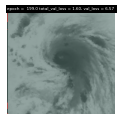

In [33]:
logging.info('training '+model_name)
start = datetime.datetime.now()
sample = random_sample(valid_index_loader)
if os.path.exists(root_path+train_save_name) == False:
    os.makedirs(root_path+train_save_name)
save_img(sample.unsqueeze(0)* (max_img - min_img) + min_img, path=f'{root_path}{train_save_name}/sample_original.jpg')
    
for epoch in range(start_epoch, epochs):  # loop over the dataset multiple times
    print('epochs [%d/%d]' % (epoch + 1, epochs))
    logging.info('epochs ['+str(epoch + 1)+'/'+str(epochs)+']')
    starttime = datetime.datetime.now()
    # train data
    total_train_loss = 0
    train_cnt = 0
    for _data, _target in tqdm(train_index_loader):
        data = _data.cuda()
        target = _target.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        pred, _, _, _ = model.forward(data)
        optimizer.zero_grad()
        loss = criterion(pred, target)
        total_train_loss += loss.item()
        train_cnt += 1
        loss.backward()
        optimizer.step()
    
    total_val_loss = 0
    val_cnt = 0
    for _data, _target in tqdm(valid_index_loader):
        data = _data.cuda()
        target = _target.cuda()
        # zero the parameter gradients
        # forward + backward + optimize
        pred, _, _, _ = model.forward(data)
        optimizer.zero_grad()
        loss = criterion(pred, target)
        val_cnt += 1
        total_val_loss += loss.item()
    
    if min_val_loss > total_val_loss:
        checkpoint = {
             'epoch': epoch+1, # next epoch
             'model': model.state_dict(),
             'optimizer': optimizer.state_dict(),
             'min_val_loss': total_val_loss
        }
        torch.save(checkpoint, model_dir + '/' + 'best_validate_model.pth')
        print('Saving Model in epoch', epoch+1)
        logging.info('Saving Model in epoch '+str(epoch+1))
        min_val_loss = total_val_loss       
        early_stop_counter = 0
    
    endtime = datetime.datetime.now()
    _, _, _, resized = model(sample.unsqueeze(0))
    x1 = resized[0].data * (max_img - min_img) + min_img
    
    save_img(x1, path=f'{root_path}{train_save_name}/epoch_{epoch}@2x.jpg', annotation=f'epoch = {epoch: .1f} total_val_loss = {total_train_loss/train_cnt:.2f}, val_loss = {total_val_loss/val_cnt:.2f}')
  
    print('cost:%fs total_train_loss: %.8f val_loss: %.8f' % ((endtime - starttime).seconds,total_train_loss/train_cnt, total_val_loss/val_cnt))
    logging.info('cost:'+str((endtime - starttime).seconds)+'s train_loss:'+str(total_train_loss/train_cnt)+' val_loss: '+str(total_val_loss/val_cnt))
    
    early_stop_counter += 1
    if early_stop_counter >= patient:
        print('Early Stop Training')
        logging.info('Early Stop Training')
        break
end = datetime.datetime.now()    
print('Finished Training')
print('Total cost: %fs'%(end-start).seconds)
logging.info('Finished Training')
logging.info('Total cost:' + str((end-start).seconds)+ 's')

# Testing Result

show the tesing result

In [21]:
test_info = data_info[(data_info["YEAR"]>=test_range[0]) & (data_info["YEAR"]<=test_range[1])].copy()

In [22]:
X = test_info["PATH"].to_numpy()
Y = test_info["WIND_SPEED"].to_numpy()
Y = np.expand_dims(Y, axis=1)

In [23]:
checkpoint = torch.load(model_dir + '/' + 'best_validate_model.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [24]:
test_list = []
pred_list = []
test_indexset = LiverDataset([*range(0, len(X))])
test_index_loader = DataLoader(dataset=test_indexset,batch_size=64,shuffle=False,)

In [25]:
model.eval()
with torch.no_grad():
    for _data,_target in tqdm(test_index_loader):
        data = _data.cuda()
        pred, _, _, _  = model(data, )
        target = _target.cpu().detach().numpy()
        pred_list.extend(pred.cpu().detach().numpy())
        test_list.extend(target)

100%|██████████| 254/254 [00:32<00:00,  7.73it/s]


In [26]:
index_2018 = 0
index_2019 = 0
index_2020 = 0
for i in range(len(X)):
    if int(X[i].split('/')[-2][:4])==2018:
        index_2018 = i
    elif int(X[i].split('/')[-2][:4])==2019:
        index_2019 = i
    elif int(X[i].split('/')[-2][:4])==2020:
        index_2020 = i
index_2018 += 1
index_2019 += 1
index_2020 += 1

In [27]:
index_2018, index_2019, index_2020

(6650, 12257, 16206)

In [28]:
def get_mae(test, pred):
    result = []
    for i in range(len(test)):
        result.append(np.abs(test[i]-pred[i])[0])
    return sum(result)/len(result)

In [29]:
mae_2018 = get_mae(test_list[:index_2018], pred_list[:index_2018])
mae_2019 = get_mae(test_list[index_2018:index_2019], pred_list[index_2018:index_2019])
mae_2020 = get_mae(test_list[index_2019:index_2020], pred_list[index_2019:index_2020])
maes = get_mae(test_list, pred_list)
print('MAE in 2018:', mae_2018)
print('MAE in 2019:', mae_2019)
print('MAE in 2020:', mae_2020)
print('MAE in avg:', maes)
logging.info('testing '+model_name)
logging.info('MAE in 2018:'+str(mae_2018))
logging.info('MAE in 2019:'+str(mae_2019))
logging.info('MAE in 2020:'+str(mae_2020))
logging.info('MAE in avg:'+str(maes))

MAE in 2018: 8.08286797086099
MAE in 2019: 8.469844086573726
MAE in 2020: 7.850983751306174
MAE in avg: 8.160250687001886


In [30]:
def get_rmse(test, pred):
    result = []
    for i in range(len(test)):
        result.append(np.square(test[i]-pred[i])[0])
    return np.sqrt(sum(result)/len(result))

In [31]:
rmse_2018 = get_rmse(test_list[:index_2018], pred_list[:index_2018])
rmse_2019 = get_rmse(test_list[index_2018:index_2019], pred_list[index_2018:index_2019])
rmse_2020 = get_rmse(test_list[index_2019:index_2020], pred_list[index_2019:index_2020])
rmses = get_rmse(test_list, pred_list)
print('RMSE in 2018:', rmse_2018)
print('RMSE in 2019:', rmse_2019)
print('RMSE in 2020:', rmse_2020)
print('RMSE in avg:', rmses)
logging.info('testing '+model_name)
logging.info('RMSE in 2018:'+str(rmse_2018))
logging.info('RMSE in 2019:'+str(rmse_2019))
logging.info('RMSE in 2020:'+str(rmse_2020))
logging.info('RMSE in avg:'+str(rmses))

RMSE in 2018: 10.759023456973368
RMSE in 2019: 11.540997981539844
RMSE in 2020: 10.353836420222928
RMSE in avg: 10.9409915441213
